## Import given data

In [69]:
import pandas as pd
import numpy as np
import json
import re

import matplotlib.pyplot as plt

In [70]:
## import initial data
filtrato = pd.read_csv('data/input/storico_filtrato.csv', decimal=',')
ordini = pd.read_csv('data/input/storico_ordini.csv')
pianificazione = pd.read_csv('data/input/storico_pianificazione.csv')


## EDA on Given datasets

### lista_articoli.csv

cod_articolo $\times$ caratteristiche

In [71]:
articoli = pd.read_csv('data//input/lista_articoli.csv', decimal=',')      # add dtype={'programma ribobinatura S': np.int64}?

articoli.info()
articoli.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   codarticolo               616 non-null    object 
 1   descrizione               616 non-null    object 
 2   anima                     616 non-null    object 
 3   copertura                 616 non-null    object 
 4   spire_reali               616 non-null    int64  
 5   velocita calcolata        616 non-null    int64  
 6   kg_ora                    616 non-null    float64
 7   spandex                   616 non-null    float64
 8   ciclo                     616 non-null    object 
 9   no_cicli                  616 non-null    int64  
 10  ore_levata                616 non-null    float64
 11  Divisore                  57 non-null     float64
 12  peso elastomero           558 non-null    float64
 13  Peso spola                580 non-null    float64
 14  programma 

,codarticolo,descrizione,anima,copertura,spire_reali,velocita calcolata,kg_ora,spandex,ciclo,no_cicli,ore_levata,Divisore,peso elastomero,Peso spola,programma ribobinatura S,programma ribobinatura Z,programma termofissaggio,kw tempo,kw percentuale,fine validita
0,10353ZF,"Ly 78/44f13 Z tpm 1100 st. 2,6 (CG)",Lycra 78 162C,44f13 test. S PA 66,1050,17200,1.87,2.76,2 x 4 gg (192),2,96.0,NaN,530.0,435.0,NaN,25,4.0,NaN,NaN,NaN
1,10369ZF/2013,"Cr 44/78f18 Z tpm 600 st. 3,7 (DH)",Creora 44 H350,78f18 Z PA 6 vari colori,600,13200,3.15,1.49,5 x 3 gg + 4 h (378),5,75.6,NaN,550.0,803.0,NaN,41,6.0,NaN,NaN,NaN
2,10369ZF2,"Cr 44/78f18 Z tpm 600 st. 3,7 (DH)",Creora 44 H350,78f18 Z PA 6 francia e nero,600,13200,3.15,1.49,5 x 3 gg + 4 h (378),5,75.6,NaN,550.0,803.0,NaN,41,11.0,NaN,NaN,NaN
3,10985ZF,"Ly44/78f68 Z tpm 1000 st. 3,3 (DD)",Lycra 44 162C,78f68 test. S PA 66,960,13500,2.05,1.10,4 x 4 gg + 22 h (472),4,118.0,NaN,517.0,820.0,NaN,41,11.0,NaN,NaN,NaN
4,10985ZF spole 880 gr,"Ly44/78f68 Z tpm 1000 st. 3,3 (DD)",Lycra 44 162C,78f68 test. S PA 66,960,12300,1.87,1.00,3 x 5 gg + 19 h (417) 420 gr lycra,3,139.0,NaN,517.0,880.0,NaN,41,11.0,NaN,NaN,NaN


#### Controllo totale ore

In [72]:
df = articoli.copy()

## add totale ore
df = df.loc[:, ["codarticolo", "ciclo", "no_cicli", "ore_levata"]]

# check ore
df['totale_ore descritto'] = df['ciclo'].str.extract(r'\(( *\d+(?:,\d+)*)\)')
df['totale_ore descritto'] = df['totale_ore descritto'].str.replace(',', '.').astype(float)

df['totale_ore'] = df['no_cicli'] * df['ore_levata']
df['verifica ore'] = np.equal(df['no_cicli'] * df['ore_levata'], df['totale_ore descritto'])
df['differenza ore'] = np.sqrt((df['totale_ore'] - df['totale_ore descritto'].where(df['totale_ore descritto'].notna(), 0).astype(int))**2)

average_percentage = (df['verifica ore'].sum() / df['verifica ore'].count()) * 100
print(f"Totale ore in Ciclo e totale ore calcolate con ore_levata * no_cicli combaciano nel: \n{average_percentage:.2f}%")

df.head()

Totale ore in Ciclo e totale ore calcolate con ore_levata * no_cicli combaciano nel: 
56.66%


,codarticolo,ciclo,no_cicli,ore_levata,totale_ore descritto,totale_ore,verifica ore,differenza ore
0,10353ZF,2 x 4 gg (192),2,96.0,192.0,192.0,True,0.0
1,10369ZF/2013,5 x 3 gg + 4 h (378),5,75.6,378.0,378.0,True,0.0
2,10369ZF2,5 x 3 gg + 4 h (378),5,75.6,378.0,378.0,True,0.0
3,10985ZF,4 x 4 gg + 22 h (472),4,118.0,472.0,472.0,True,0.0
4,10985ZF spole 880 gr,3 x 5 gg + 19 h (417) 420 gr lycra,3,139.0,417.0,417.0,True,0.0


Per visualizzare le righe ambigue modificare epsilon (tolleranza):

In [73]:
epsilon = 5      # minimo differenza
ambiguo = df[df['verifica ore'] == False].where((np.sqrt(df['differenza ore'] ** 2)) > epsilon).dropna(subset=['codarticolo'])
print(f"Totale righe: {df.shape[0]}")
print(f"Righe ambigue: {ambiguo.shape[0]}")
ambiguo

Totale righe: 616
Righe ambigue: 43


,codarticolo,ciclo,no_cicli,ore_levata,totale_ore descritto,totale_ore,verifica ore,differenza ore
5,10996SN,3 x 3 gg + 20 h (278),3.0,95.00,278.0,285.00,False,7.00
16,13005ZF-14000,3 x 4 gg + 22 h (345),3.0,118.00,345.0,354.00,False,9.00
30,15613DN1,1 x 18 gg (432) /2,2.0,429.00,432.0,858.00,False,426.00
44,1723ZN1,6 x 5 gg + 22 h (850),4.0,169.00,850.0,676.00,False,174.00
45,1723ZN2,6 x 5 gg + 22 h (850),4.0,169.00,850.0,676.00,False,174.00
59,20098DN,5 x 1 gg + 22 h (230),3.0,46.00,230.0,138.00,False,92.00
60,20098DN-VARI COL,5 x 1 gg + 22 h (230),3.0,46.00,230.0,138.00,False,92.00
74,2221ZN,10 x 3 gg (725),3.0,24.16,725.0,72.48,False,652.52
102,2254ZN-11400,4 x 6 gg + 17 h (464),4.0,161.00,464.0,644.00,False,180.00
191,31004DN220379,2 x 3 gg + 20 h (92)/2,2.0,92.00,92.0,184.00,False,92.00


<Axes: xlabel='differenza ore', ylabel='Count'>

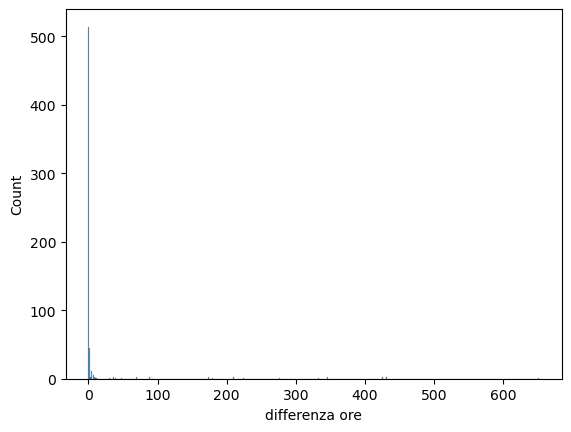

In [74]:
# plot differenza ore

import seaborn as sns

df['differenza ore'].describe()

sns.histplot(df['differenza ore'], bins=500)



##### Controllo numero cicli

In [75]:
# check cicli
df['no_cicli descritto'] = df['ciclo'].str.extract(r'(\d{0,2})').astype(int)
df['differenza cicli'] = df['no_cicli'] - df['no_cicli descritto']
df['verifica cicli'] = np.equal(df['no_cicli descritto'], df['no_cicli'])

average = (df['verifica cicli'].sum() / df['verifica cicli'].count())*100

print(f"no_cicli combaciano nel {average:.2f}%")
df[df['verifica cicli'] == False]

no_cicli combaciano nel 94.81%


,codarticolo,ciclo,no_cicli,ore_levata,totale_ore descritto,totale_ore,verifica ore,differenza ore,no_cicli descritto,differenza cicli,verifica cicli
9,11007SF 3 cicli,2 x 16 gg (1154),3,385.00,1154.0,1155.00,False,1.00,2,1,False
11,11011ZF2,7 x 8 gg (1345),6,224.17,1345.0,1345.02,False,0.02,7,-1,False
28,15611DN,2 x 2 gg + 23 h (141) /2,4,35.25,141.0,141.00,True,0.00,2,2,False
30,15613DN1,1 x 18 gg (432) /2,2,429.00,432.0,858.00,False,426.00,1,1,False
44,1723ZN1,6 x 5 gg + 22 h (850),4,169.00,850.0,676.00,False,174.00,6,-2,False
45,1723ZN2,6 x 5 gg + 22 h (850),4,169.00,850.0,676.00,False,174.00,6,-2,False
59,20098DN,5 x 1 gg + 22 h (230),3,46.00,230.0,138.00,False,92.00,5,-2,False
60,20098DN-VARI COL,5 x 1 gg + 22 h (230),3,46.00,230.0,138.00,False,92.00,5,-2,False
74,2221ZN,10 x 3 gg (725),3,24.16,725.0,72.48,False,652.52,10,-7,False
117,2269ZF2,5 x 5 gg + 21 h (706),4,176.50,706.0,706.00,True,0.00,5,-1,False


In alcuni casi i cicli sono diversi ma le ore sono uguali:

In [76]:
ambiguo = df[(df['verifica cicli'] == False) & (df['verifica ore'] == True)]
ambiguo.loc[:, ['codarticolo',  'ciclo', 'no_cicli','no_cicli descritto', 'ore_levata', 'totale_ore', 'totale_ore descritto', 'verifica ore', 'verifica cicli']]

,codarticolo,ciclo,no_cicli,no_cicli descritto,ore_levata,totale_ore,totale_ore descritto,verifica ore,verifica cicli
28,15611DN,2 x 2 gg + 23 h (141) /2,4,2,35.25,141.0,141.0,True,False
117,2269ZF2,5 x 5 gg + 21 h (706),4,5,176.50,706.0,706.0,True,False
118,2269ZN/F2,5 x 5 gg + 21 h (706),4,5,176.50,706.0,706.0,True,False
119,2269ZN2,5 x 5 gg + 21 h (706),4,5,176.50,706.0,706.0,True,False
153,23502DN-150053,2 x 3 gg + 18 h (181) /2,4,2,45.25,181.0,181.0,True,False
154,23502DN-9025,2 x 3 gg + 18 h (181) /2,4,2,45.25,181.0,181.0,True,False
155,23502DN-T0001,2 x 3 gg + 18 h (181) /2,4,2,45.25,181.0,181.0,True,False
187,31002DN1,1 x 5 gg + 20 h (140) /2,2,1,70.00,140.0,140.0,True,False
264,62002DN,1 x 4 gg (96) /2,2,1,48.00,96.0,96.0,True,False
314,S15-60008V2DN2,2 x 1 gg + 19 h (43),1,2,43.00,43.0,43.0,True,False


Vedo cosa cambia usando 'no_cicli' (v1) o 'no_cicli descritto' (v2):

In [77]:
tolleranza = 2

df['totale_ore v2'] = df['no_cicli descritto'] * df['ore_levata']
df['differenza ore v2'] = np.sqrt((df['totale_ore descritto'] - df['totale_ore v2'])**2)

v1 = df.where(df['differenza ore'] > tolleranza).dropna(subset='codarticolo')
v2 = df.where(df['differenza ore v2'] > tolleranza).dropna(subset='codarticolo')

print(f"v1.len = {v1.shape[0]}")
print(f"v2.len = {v2.shape[0]}")

v1.len = 57
v2.len = 58


$\implies$ non cambia praticamente nulla, anzi peggiora $\implies$ uso 'no_cicli'

##### Dataset valido

In [78]:
# ok = df[(df['verifica ore'] == True) & df['verifica cicli'] == True]
tolleranza = 10
ok = df[(df['differenza ore'] < tolleranza)] 

print(f"numero righe originarie: {df.shape[0]}")
print(f"numero righe non ambigue: {ok.shape[0]}")
print(f"percentuale dataset valido: {(ok.shape[0] / df.shape[0])*100:.2f}%")

numero righe originarie: 616
numero righe non ambigue: 581
percentuale dataset valido: 94.32%


#### Add totale kg

Per aggiungere totale kg abbiamo bisogno delle *ore_totale* veritiere $\implies$ per ora consideriamo solo dataset valido

In [79]:
valid = articoli.where(articoli['codarticolo'].isin(ok['codarticolo'])).dropna(subset='codarticolo')
print(f"n_righe: {valid.shape[0]}")

df = valid

## add totale kg
df['totale_ore'] = df['ore_levata'] * df['no_cicli']
df['totale_kg'] = df['totale_ore'] * df['kg_ora']
df.head()

n_righe: 581


,codarticolo,descrizione,anima,copertura,spire_reali,velocita calcolata,kg_ora,spandex,ciclo,no_cicli,...,peso elastomero,Peso spola,programma ribobinatura S,programma ribobinatura Z,programma termofissaggio,kw tempo,kw percentuale,fine validita,totale_ore,totale_kg
0,10353ZF,"Ly 78/44f13 Z tpm 1100 st. 2,6 (CG)",Lycra 78 162C,44f13 test. S PA 66,1050.0,17200.0,1.87,2.76,2 x 4 gg (192),2.0,...,530.0,435.0,NaN,25,4.0,NaN,NaN,NaN,192.0,359.04
1,10369ZF/2013,"Cr 44/78f18 Z tpm 600 st. 3,7 (DH)",Creora 44 H350,78f18 Z PA 6 vari colori,600.0,13200.0,3.15,1.49,5 x 3 gg + 4 h (378),5.0,...,550.0,803.0,NaN,41,6.0,NaN,NaN,NaN,378.0,1190.70
2,10369ZF2,"Cr 44/78f18 Z tpm 600 st. 3,7 (DH)",Creora 44 H350,78f18 Z PA 6 francia e nero,600.0,13200.0,3.15,1.49,5 x 3 gg + 4 h (378),5.0,...,550.0,803.0,NaN,41,11.0,NaN,NaN,NaN,378.0,1190.70
3,10985ZF,"Ly44/78f68 Z tpm 1000 st. 3,3 (DD)",Lycra 44 162C,78f68 test. S PA 66,960.0,13500.0,2.05,1.10,4 x 4 gg + 22 h (472),4.0,...,517.0,820.0,NaN,41,11.0,NaN,NaN,NaN,472.0,967.60
4,10985ZF spole 880 gr,"Ly44/78f68 Z tpm 1000 st. 3,3 (DD)",Lycra 44 162C,78f68 test. S PA 66,960.0,12300.0,1.87,1.00,3 x 5 gg + 19 h (417) 420 gr lycra,3.0,...,517.0,880.0,NaN,41,11.0,NaN,NaN,NaN,417.0,779.79


#### Add consumo energetico

In [80]:
## add consume energetico
print(f"Abbiamo dati del consumo energito per {df['kw tempo'].notna().sum()} righe su {valid.shape[0]} totali.")
df[df['kw percentuale'].notna()].head()

Abbiamo dati del consumo energito per 23 righe su 581 totali.


,codarticolo,descrizione,anima,copertura,spire_reali,velocita calcolata,kg_ora,spandex,ciclo,no_cicli,...,peso elastomero,Peso spola,programma ribobinatura S,programma ribobinatura Z,programma termofissaggio,kw tempo,kw percentuale,fine validita,totale_ore,totale_kg
16,13005ZF-14000,"Ly130/33f20 Z tpm 900 st. 4,2 (EC)",Lycra 130 902C,33f20 parallelo PA 66,855.0,14000.0,1.60,2.96,3 x 4 gg + 22 h (345),3.0,...,1046.0,390.0,NaN,26,11.0,05:00:00,1.0,NaN,354.0,566.400
17,13005ZF-600gr,"Ly130/33f20 Z tpm 900 st. 4,2 (EC)",Lycra 130 902C,33f20 parallelo PA 66,855.0,14500.0,1.69,3.07,2 x 4 gg (192),2.0,...,1046.0,370.0,NaN,26,11.0,05:00:00,1.0,NaN,192.0,324.480
18,13005ZF 17600,"Ly130/33f20 Z tpm 900 st. 4,2 (EC)",Lycra 130 902C,33f20 parallelo PA 66,855.0,18000.0,2.09,3.80,3 x 3 gg + 21 h (277),3.0,...,1046.0,420.0,NaN,26,11.0,05:00:00,1.0,NaN,276.9,578.721
20,13007Z,"Ly130/33f20 Z tpm 900 st. 4,2 (EC)",Lycra 130 902C,33f20 test. S PA 66,900.0,18000.0,2.09,3.80,3 x 3 gg + 21 h (277),3.0,...,1046.0,420.0,NaN,26,11.0,05:00:00,1.0,NaN,276.9,578.721
21,13007ZF 903C 14000,"Ly130/33f20 Z tpm 900 st. 4,2 (EC)",Lycra 130 903C,33f20 test. S PA 66,900.0,14000.0,1.59,2.94,3 x 4 gg + 19 h (346),3.0,...,1020.0,380.0,NaN,19,11.0,05:00:00,1.0,NaN,345.0,548.550


#### Chiarimenti

Non è chiaro come procedere quando:
- in ciclo è presente **/2**
- totale ore calcolate e ore in *ciclo* non combaciano
- no_cicli e no_cicli in *ciclo* non combaciano
- totale ore combaciano ma no_cicli no
- *ciclo* non segue il patern: **no_cicli $\times$ n_giorni + n_ore**

Inoltre:
- a cosa servono *kw_tempo* e *kw_percentuale*?

In [81]:
# Save valid dataset
valid.to_csv('data/valid/lista_articoli.csv', index=False)

### storico_filtrato.csv

articolo $\times$ dati dalle macchine

In [82]:
filtrato = pd.read_csv('data/input/storico_filtrato.csv', decimal=',')

filtrato.info()
filtrato.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   N° MC                        1 non-null      object 
 1   Unnamed: 1                   4 non-null      object 
 2   Unnamed: 2                   654 non-null    object 
 3   Unnamed: 3                   651 non-null    float64
 4   cod articolo                 651 non-null    object 
 5   descrizione                  626 non-null    object 
 6   N° fusi reali                360 non-null    float64
 7   velocita fusi inferiori      647 non-null    float64
 8   data ora partenza            651 non-null    object 
 9   data ora fine                651 non-null    object 
 10  data ora fine manuale        30 non-null     object 
 11  ore lavorate dalla partenza  602 non-null    float64
 12  KWh assorbiti                602 non-null    float64
 13  KW medi             

,N° MC,Unnamed: 1,Unnamed: 2,Unnamed: 3,cod articolo,descrizione,N° fusi reali,velocita fusi inferiori,data ora partenza,data ora fine,data ora fine manuale,ore lavorate dalla partenza,KWh assorbiti,KW medi,produzione [kg],KWh/Kg,€/Kg,note,N° scheda
0,-,Anno Inizio : 2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,-,Mese Inizio : 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,+,1.0,2277DN mini,"Ly22/8f5 dc tpm 2100 st. 3,4 (DE)",NaN,20194.0,11/04/2024 14:20:33,29/04/2024 21:59:49,NaN,439.48,5921.32,13.4735,121.47,48.74,10.72,x la 7°levata vedere se mettere lycra 22 usata...,NaN
3,NaN,NaN,+,2.0,2011DN mini,"Ly 20/13f10 dc tpm 2400 st. 3,0 (DA)",NaN,21112.0,03/04/2024 13:41:13,17/04/2024 04:36:25,NaN,326.78,5583.02,17.0850,135.82,41.11,9.04,NaN,NaN
4,NaN,NaN,+,3.0,2011DN mini,"Ly 20/13f10 dc tpm 2400 st. 3,0 (DA)",448.0,21026.0,24/04/2024 12:34:52,08/05/2024 07:06:28,NaN,330.38,5914.74,17.9028,137.49,43.02,9.46,NaN,NaN


Eliminiamo le colonne *unnamed* e le righe *nan* dovute alla formattazione *nested*:

In [83]:
# sistema storico_filtrato

df = filtrato.copy()

df.drop(columns='N° MC', inplace=True)
df.rename(columns={
    'Unnamed: 1': 'anno inizio',
    'Unnamed: 2': 'mese articolo',
    'Unnamed: 3': 'N_mc'
    }, 
    inplace=True
)
df.dropna(subset=['data ora partenza'], inplace=True)

df['anno inizio'] = df['data ora partenza'].apply(lambda x: x.split(' ')[0].split('/')[2])
df['mese articolo'] = df['data ora partenza'].apply(lambda x: x.split(' ')[0].split('/')[1])

filtrato = df.copy()

df.head(2)

,anno inizio,mese articolo,N_mc,cod articolo,descrizione,N° fusi reali,velocita fusi inferiori,data ora partenza,data ora fine,data ora fine manuale,ore lavorate dalla partenza,KWh assorbiti,KW medi,produzione [kg],KWh/Kg,€/Kg,note,N° scheda
2,2024,04,1.0,2277DN mini,"Ly22/8f5 dc tpm 2100 st. 3,4 (DE)",NaN,20194.0,11/04/2024 14:20:33,29/04/2024 21:59:49,NaN,439.48,5921.32,13.4735,121.47,48.74,10.72,x la 7°levata vedere se mettere lycra 22 usata...,NaN
3,2024,04,2.0,2011DN mini,"Ly 20/13f10 dc tpm 2400 st. 3,0 (DA)",NaN,21112.0,03/04/2024 13:41:13,17/04/2024 04:36:25,NaN,326.78,5583.02,17.0850,135.82,41.11,9.04,NaN,NaN


Trasformo le colonne *data* in *datetime*

In [84]:
df['data partenza'] = df['data ora partenza'].apply(lambda x: x.split(' ')[0])
df['ora partenza'] = df['data ora partenza'].apply(lambda x: x.split(' ')[1])

df['data fine'] = df['data ora fine'].apply(lambda x: x.split(' ')[0])
# df['ora fine'] = df['data ora fine'].apply(lambda x: x.split(' ')[1])     # TODO: non tutte le righe hanno l'ora, non serve

df['data partenza'] = pd.to_datetime(df['data partenza'], format='%d/%m/%Y')
df['data fine'] = pd.to_datetime(df['data fine'], format='%d/%m/%Y')

df['durata (giorni)'] = df['data fine'] - df['data partenza']
df['durata (giorni)'] = df['durata (giorni)'].apply(lambda x: x.days)

df.head(1)

,anno inizio,mese articolo,N_mc,cod articolo,descrizione,N° fusi reali,velocita fusi inferiori,data ora partenza,data ora fine,data ora fine manuale,...,KW medi,produzione [kg],KWh/Kg,€/Kg,note,N° scheda,data partenza,ora partenza,data fine,durata (giorni)
2,2024,04,1.0,2277DN mini,"Ly22/8f5 dc tpm 2100 st. 3,4 (DE)",NaN,20194.0,11/04/2024 14:20:33,29/04/2024 21:59:49,NaN,...,13.4735,121.47,48.74,10.72,x la 7°levata vedere se mettere lycra 22 usata...,NaN,2024-04-11,14:20:33,2024-04-29,18


In [85]:
df.info(True)
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 651 entries, 2 to 654
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   anno inizio                  651 non-null    object        
 1   mese articolo                651 non-null    object        
 2   N_mc                         651 non-null    float64       
 3   cod articolo                 651 non-null    object        
 4   descrizione                  626 non-null    object        
 5   N° fusi reali                360 non-null    float64       
 6   velocita fusi inferiori      647 non-null    float64       
 7   data ora partenza            651 non-null    object        
 8   data ora fine                651 non-null    object        
 9   data ora fine manuale        30 non-null     object        
 10  ore lavorate dalla partenza  602 non-null    float64       
 11  KWh assorbiti                602 non-null    float

,N_mc,N° fusi reali,velocita fusi inferiori,ore lavorate dalla partenza,KWh assorbiti,KW medi,produzione [kg],KWh/Kg,€/Kg,data partenza,data fine,durata (giorni)
count,651.000000,360.000000,647.000000,602.000000,602.000000,602.000000,624.000000,575.000000,575.000000,651,651,651.000000
mean,41.476190,268.880556,15973.378671,163.433538,1927.399485,9.925470,129.325913,15.894991,3.495096,2024-05-17 00:46:27.096774400,2024-05-24 09:35:06.912442624,7.367127
min,1.000000,24.000000,7000.000000,4.980000,0.120000,0.000300,0.260000,0.000000,0.000000,2024-04-01 00:00:00,2024-04-03 00:00:00,0.000000
25%,30.000000,256.000000,13195.500000,58.765000,454.525000,7.743075,92.330000,3.650000,0.805000,2024-04-24 00:00:00,2024-05-01 00:00:00,2.000000
50%,40.000000,256.000000,14623.000000,109.335000,1027.235000,10.275650,123.740000,6.680000,1.470000,2024-05-17 00:00:00,2024-05-25 00:00:00,5.000000
75%,56.500000,264.000000,19936.000000,228.420000,2723.320000,12.511100,171.005000,26.790000,5.895000,2024-06-09 00:00:00,2024-06-16 00:00:00,10.500000
max,75.000000,448.000000,21189.000000,649.520000,11224.170000,19.356400,795.300000,245.500000,54.010000,2024-06-29 00:00:00,2024-07-25 00:00:00,28.000000
std,18.640253,71.303499,4055.193289,151.716547,2231.308768,3.917078,63.858465,20.232336,4.451992,NaN,NaN,6.909220


### storico_ordini.csv

In [86]:
ordini = pd.read_csv('data/input/storico_ordini.csv', decimal=',')
ordini.info(True)
ordini.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1116 entries, 0 to 1115
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cliente                    1116 non-null   object 
 1   n. ordine cliente          973 non-null    float64
 2   n. ordine ns               761 non-null    float64
 3   data inserimento ordine    1076 non-null   object 
 4   n. ordine interno          521 non-null    float64
 5   cod articolo               1103 non-null   object 
 6   descrizione                1110 non-null   object 
 7   quantità                   1106 non-null   object 
 8   data di consegna           374 non-null    object 
 9   nr. fusi                   504 non-null    float64
 10  N° MC                      507 non-null    float64
 11  n° levate                  504 non-null    float64
 12  gg per produrre            504 non-null    float64
 13  data arrivo materia prima  92 non-null     objec

,Cliente,n. ordine cliente,n. ordine ns,data inserimento ordine,n. ordine interno,cod articolo,descrizione,quantità,data di consegna,nr. fusi,N° MC,n° levate,gg per produrre,data arrivo materia prima,Completamento ordine,prodotto kg,consegnato kg,giacenza prodotto finito,note,Evaso
0,ATHENA,NaN,10.0,30/05/2023,190.0,4463S+ZN1,"Cr44/44f34 colorwise S+Z tpm 650 st. 3,2 (DC)","850,0",31/08/2023,256.0,1.0,3.98,19.25,NaN,18/10/2024,763.51,"1.124,0","0,0",NaN,Vero
1,MICHELE LETIZIA,230094.0,18150.0,24/02/2023,105.0,X22-7806S+ZN,"Ly 78/44f72 Z tpm 900 st. 4,0 (EA)","550,0",20/03/2023,264.0,1.0,3.61,13.98,NaN,13/10/2024,497.34,"554,0",NaN,NaN,Vero
2,RADICI,2003483.0,18155.0,27/02/2023,71.0,2275S+ZN-N00,"Cr22/44f34 S+Z tpm 600 st. 3,2 (DC)","2.200,0",15/05/2023,264.0,1.0,9.37,46.06,NaN,14/11/2024,2757.27,"2.358,60",NaN,NaN,Vero
3,RADICI,2003483.0,18155.0,27/02/2023,72.0,2275S+ZN-B10A,"Cr22/44f34 S+Z tpm 600 st. 3,2 (DC)","8.500,0",30/06/2023,264.0,2.0,18.10,88.97,NaN,27/12/2024,8758.16,"8.780,90",NaN,NaN,Vero
4,RADICI,2003483.0,18155.0,27/02/2023,73.0,2276S+ZN,"Cr22/44f30 S+Z tpm 650 st. 3,2 (DC)","3.000,0",15/05/2023,256.0,2.0,6.69,38.58,NaN,07/11/2024,4296.48,"3.325,0",NaN,NaN,Vero


#### Casting

In [87]:
## date
ordini['data inserimento ordine'] = pd.to_datetime(ordini['data inserimento ordine'], format='%d/%m/%Y')
ordini['data di consegna'] = pd.to_datetime(ordini['data di consegna'], format='%d/%m/%Y')
ordini['Completamento ordine'] = pd.to_datetime(ordini['Completamento ordine'], format='%d/%m/%Y')

## quantità
ordini.dropna(subset=['quantità', 'cod articolo', 'consegnato kg'], inplace=True)

# Function to clean the 'quantità' values
def clean_quantity(value):
    # Remove , and any value after it
    cleaned_value = value.split(',')[0]
    # Remove .
    cleaned_value = cleaned_value.replace('.', '')
    return float(cleaned_value)

ordini['quantità'] = ordini['quantità'].apply(clean_quantity)
ordini['consegnato kg'] = ordini['consegnato kg'].apply(clean_quantity)

ordini.to_csv('data/valid/storico_ordini.csv', index=False)

ordini.head()

,Cliente,n. ordine cliente,n. ordine ns,data inserimento ordine,n. ordine interno,cod articolo,descrizione,quantità,data di consegna,nr. fusi,N° MC,n° levate,gg per produrre,data arrivo materia prima,Completamento ordine,prodotto kg,consegnato kg,giacenza prodotto finito,note,Evaso
0,ATHENA,NaN,10.0,2023-05-30,190.0,4463S+ZN1,"Cr44/44f34 colorwise S+Z tpm 650 st. 3,2 (DC)",850.0,2023-08-31,256.0,1.0,3.98,19.25,NaN,2024-10-18,763.51,1124.0,"0,0",NaN,Vero
1,MICHELE LETIZIA,230094.0,18150.0,2023-02-24,105.0,X22-7806S+ZN,"Ly 78/44f72 Z tpm 900 st. 4,0 (EA)",550.0,2023-03-20,264.0,1.0,3.61,13.98,NaN,2024-10-13,497.34,554.0,NaN,NaN,Vero
2,RADICI,2003483.0,18155.0,2023-02-27,71.0,2275S+ZN-N00,"Cr22/44f34 S+Z tpm 600 st. 3,2 (DC)",2200.0,2023-05-15,264.0,1.0,9.37,46.06,NaN,2024-11-14,2757.27,2358.0,NaN,NaN,Vero
3,RADICI,2003483.0,18155.0,2023-02-27,72.0,2275S+ZN-B10A,"Cr22/44f34 S+Z tpm 600 st. 3,2 (DC)",8500.0,2023-06-30,264.0,2.0,18.10,88.97,NaN,2024-12-27,8758.16,8780.0,NaN,NaN,Vero
4,RADICI,2003483.0,18155.0,2023-02-27,73.0,2276S+ZN,"Cr22/44f30 S+Z tpm 650 st. 3,2 (DC)",3000.0,2023-05-15,256.0,2.0,6.69,38.58,NaN,2024-11-07,4296.48,3325.0,NaN,NaN,Vero


### storico_pianificazione.csv

In [88]:
pianificazione = pd.read_csv('data/input/storico_pianificazione.csv', decimal=',')
pianificazione.info(True)
pianificazione.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563 entries, 0 to 562
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Cliente                      533 non-null    object 
 1   n. ordine interno            533 non-null    float64
 2   codarticolo                  533 non-null    object 
 3   descrizione                  533 non-null    object 
 4   quantità                     532 non-null    object 
 5   data di consegna             104 non-null    object 
 6   Mc No.                       450 non-null    object 
 7   data fermata prevista        274 non-null    object 
 8   data inserimento produzione  449 non-null    object 
 9   n. levate                    446 non-null    float64
 10  nr fusi effettivi            67 non-null     float64
 11  fine produzione              446 non-null    object 
 12  kg prodotti                  446 non-null    object 
 13  evaso               

,Cliente,n. ordine interno,codarticolo,descrizione,quantità,data di consegna,Mc No.,data fermata prevista,data inserimento produzione,n. levate,nr fusi effettivi,fine produzione,kg prodotti,evaso
0,MICHELE LETIZIA,105.0,X22-7806S+ZN,"Ly 78/44f72 Z tpm 900 st. 4,0 (EA)","550,0",20/03/2023,60,NaN,16/03/2023,4.0,NaN,01/04/2023,"609,9638",Vero
1,RADICI,71.0,2275S+ZN-N00,"Cr22/44f34 S+Z tpm 600 st. 3,2 (DC)","2.200,0",15/05/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vero
2,NaN,NaN,NaN,NaN,NaN,NaN,71,06/11/2024,08/03/2023,13.0,NaN,13/05/2023,"3.053,1394",NaN
3,RADICI,72.0,2275S+ZN-B10A,"Cr22/44f34 S+Z tpm 600 st. 3,2 (DC)","8.500,0",30/06/2023,55,27/09/2024,15/03/2023,21.0,NaN,29/06/2023,"4.931,9944",Vero
4,NaN,NaN,NaN,NaN,NaN,NaN,52,01/10/2024,04/03/2023,20.0,NaN,13/06/2023,"4.697,1375",NaN


Dataset prettamente per organizzazione interna, i dati rilevanti sono già disponibili negli altri files.

# Utils

## Clienti

### cliente : occorrenze_storico

In [89]:
tot_per_client = ordini['Cliente'].value_counts()

with open('data/utils/tot_per_client.json', 'w') as f:
    json.dump(tot_per_client.to_dict(), f)

tot_per_client.head(20)

Cliente
SANYLEG                        134
CALZIFICIO TREVER               74
DIAMANT                         71
GIZETA                          67
CALZIFICIO NUOVO GIODI          39
FALKE                           34
CSP PARIS                       33
MANIFATTURA ITALIA CUCIRINI     27
BBF GAMBETTI                    24
CALZIFICIO TEX STYLE            22
FGP                             22
MARYGOLD                        21
CSP INTERNATIONAL               19
CALZIFICIO SANBA                16
CALZIFICIO CREMONA              16
RADICI                          15
CALZIFICIO POLAR                12
FISHER & PAYKEL                 12
CALZIFICIO GENNY                11
ATHENA                          11
Name: count, dtype: int64

### cliente : {articolo : occorrenze}

In [90]:
# aux function to count occurrences of each 'cod articolo'
def count_articles(group):
    return group['cod articolo'].value_counts().to_dict()

# Group by 'Cliente' and apply the custom function
ordini_per_client = ordini.groupby('Cliente').apply(count_articles)

with open('data/utils/ordini_per_client.json', 'w') as file:
    json.dump(ordini_per_client.to_dict(), file)

# Display the result
print(ordini_per_client.head())

Cliente
ALLERGO SYSTEM                                       {'4462ZN2': 6}
ALPIN CORAP                          {'23505DN1': 2, '23505DN2': 2}
AMBROFIBRE        {'X23-2280S+ZN': 3, 'X21-4480S+ZN': 1, 'X23-22...
APPLE             {'S18-60042V4DN': 2, 'S18-60042V2DN': 1, 'S15-...
ATHENA            {'4463S+ZN1': 7, '4457ZN2': 1, 'X22-7810S-ZN35...
dtype: object


In [91]:
ordini_per_client['ALLERGO SYSTEM'] == ordini_per_client[0]

True

In [92]:
ordini_per_client.keys()

Index(['ALLERGO SYSTEM', 'ALPIN CORAP', 'AMBROFIBRE', 'APPLE', 'ATHENA',
       'AUSSCO', 'BBF GAMBETTI', 'BORN', 'BRAM', 'BRUNO CHIARUTTINI SRL',
       'BUCAN D.O.O.', 'CALZE LUISA', 'CALZE OLONA', 'CALZIFICIO ARGOPI',
       'CALZIFICIO ATHENA', 'CALZIFICIO BELLAFONTE', 'CALZIFICIO BRAM',
       'CALZIFICIO C&LD', 'CALZIFICIO CAROL', 'CALZIFICIO CREMONA',
       'CALZIFICIO DUE C', 'CALZIFICIO FIONI', 'CALZIFICIO GENNY',
       'CALZIFICIO LUISA', 'CALZIFICIO NEGRISOLI', 'CALZIFICIO NUOVO GIODI',
       'CALZIFICIO POLAR', 'CALZIFICIO SANBA', 'CALZIFICIO TEX STYLE',
       'CALZIFICIO TREVER', 'CALZIFICIO VACCARI', 'CALZIFICIO ZETA',
       'CHRIMARTEX', 'CSP INTERNATIONAL', 'CSP PARIS', 'DIAMANT', 'DUELEGS',
       'EREBUS', 'ESTAMBRIL TEXTILES INTERNATIONAL S.L.', 'FALKE',
       'FEIN ELAST GRABHER', 'FF', 'FGP', 'FILTRADING', 'FISHER & PAYKEL',
       'FOCENZA FACTORY', 'FRITSCHE', 'FROHN GMBH', 'GI TESSIL FODERAMI',
       'GIZETA', 'GREENFLEX BV', 'GT 2000', 'GUSTAV GERSTER', 

## Articoli

### articolo : (occorrenze, occ_normalizzate)

In [93]:
# per ogni articolo conta occorrenze
uso_per_articolo = df['cod articolo'].value_counts()
uso_norm = uso_per_articolo / df['cod articolo'].count()

# Create the dictionary
articolo_dict = {
    articolo: {
        'tot': int(uso_per_articolo[articolo]),
        'norm': float(uso_norm[articolo])
    }
    for articolo in uso_per_articolo.index
}

with open('data/utils/uso_per_articolo.json', 'w') as f:
    json.dump(articolo_dict, f, indent=4)

### cliente, articolo : mean_quantity, std_quantity, mean_giorni_ordine

In [94]:
ordini = pd.read_csv('data/valid/storico_ordini.csv')

ordini['data inserimento ordine'] = pd.to_datetime(ordini['data inserimento ordine'])
ordini['data di consegna'] = pd.to_datetime(ordini['data di consegna'])

# Calculate the difference in days between 'data_inserimento' and 'data_consegna'
ordini['differenza_giorni'] = (ordini['data di consegna'] - ordini['data inserimento ordine']).dt.days

# Group by 'Cliente' and 'cod articolo' and calculate mean and std of 'quantità'
quantity_per_client = ordini.groupby(['Cliente', 'cod articolo'])['quantità'].agg(['mean', 'std'])
quantity_per_client.fillna(0, inplace=True)

# Calculate the mean of 'differenza_giorni' for each group
mean_differenza_giorni = ordini.groupby(['Cliente', 'cod articolo'])['differenza_giorni'].mean().round()

# Merge the mean difference into the existing DataFrame
filler = ordini['differenza_giorni'].mean().round()
quantity_per_client = quantity_per_client.merge(mean_differenza_giorni, on=['Cliente', 'cod articolo'], how='left')
quantity_per_client.rename(columns={'differenza_giorni': 'mean_differenza_giorni'}, inplace=True)
quantity_per_client.fillna(value={'mean_differenza_giorni': filler}, inplace=True)                  # fill NaN values with filler
quantity_per_client['mean_differenza_giorni'].replace(0, filler, inplace=True)                      # replace 0 with filler
quantity_per_client = quantity_per_client[quantity_per_client['mean_differenza_giorni'] > 0]        # non-negative values

# Save the updated DataFrame to a CSV file
quantity_per_client.to_csv('data/utils/quantity_per_client.csv')

# Display the first few rows of the updated DataFrame
print(quantity_per_client.describe())

# TODO: add peso medio per cliente

quantity_per_client.head()

              mean          std  mean_differenza_giorni
count   316.000000   316.000000              316.000000
mean    297.241824    96.946487               29.316456
std     476.097609   289.379777               18.588984
min       0.000000     0.000000                1.000000
25%      40.000000     0.000000               26.000000
50%     144.750000     0.000000               26.000000
75%     346.875000    68.255094               26.000000
max    4366.666667  3580.968212              123.000000


mean         std  mean_differenza_giorni
Cliente        cod articolo                                                
ALLERGO SYSTEM 4462ZN2        70.166667   28.505555                    20.0
ALPIN CORAP    23505DN1        7.500000    3.535534                    26.0
               23505DN2       35.000000   21.213203                    26.0
AMBROFIBRE     X21-4480S+ZN  160.000000    0.000000                    26.0
               X23-2280S+ZN  506.666667  440.037877                    26.0

### articolo : [macchine (in base a storico)]

In [95]:
df = filtrato.loc[:, ['N_mc', 'cod articolo']]
df.columns = ['N_mc', 'cod articolo']

# switch columns
df = df[['cod articolo', 'N_mc']]
df.dropna(inplace=True)
df.head()

articoli_df = df

articoli = {}
for key in df['cod articolo'].unique():
    values = [int(v) for v in df[df['cod articolo'] == key].loc[:, 'N_mc'].unique()]
    articoli[key] = values

with open('data/utils/articoli.json', 'w') as f:
    json.dump(articoli, f, skipkeys=True, ensure_ascii=False, indent=4)

articoli = json.load(open('data/utils/articoli.json'))
articoli

{'2277DN mini': [1, 7],
 '2011DN mini': [2, 3, 4, 5],
 '2271DN 20700 mini': [5, 8, 9, 10, 11, 12, 47, 48, 62, 63, 64, 65, 66, 61],
 '749DN mini': [6, 49, 50],
 'X22-1703DN minispole': [7],
 'X23-3399S+ZF': [13, 44],
 '2270s+z rpm 19800': [14],
 '2270S+ZN 19800': [15, 16, 17, 19, 20, 26],
 'X23-2299V5ZF': [18, 72],
 '7032S+ZN': [18],
 '2270s+z rpm 21000': [21],
 '2250S+ZN': [22],
 '31002DN1': [23],
 'X24-4401S+ZF2': [24],
 'X23-4493S+ZF': [24, 25],
 'X21-2291SF': [25],
 'X21-2291sf': [25],
 '2270S+ZN mini': [26],
 'X21-2099S+ZN mini': [27, 28, 33, 34],
 'X24-2001S+ZN': [28, 60],
 '13007ZN/F-14500': [29, 30, 32, 43],
 '28503ZN': [29],
 '2246ZN 10800': [31, 44],
 'X23-2280S+ZN': [35],
 'X20-2222DN2 mini': [36],
 '33002DN': [37, 41],
 's22-700011DN': [37],
 'S600A04DN': [37],
 'S600A03DN': [37],
 '33001DN2': [38, 41, 67],
 'X23-8397DN': [38],
 '31003DN220274': [39, 40],
 'X21-39599V7DN0332': [39],
 '62002DN': [39],
 '39502DN-14446': [39],
 '39502dn': [39],
 '62002DN2': [39],
 'X21-20099DN2

### articolo : [macchine abilitate]

In [96]:
with open('data/utils/articoli_macchine_storico.json', 'r') as f:
    articoli = json.load(f)

with open('data/utils/macchine_info.json', 'r') as f:
    macchine = json.load(f)

# macchine per gruppo
gruppi = {}

for i, m in enumerate(macchine):
    group = macchine[i]['classe']
    if group not in gruppi.keys():
        gruppi[group] = []
    gruppi[group].append(m['N_mc'])

with open('data/utils/gruppi_macchine.json', 'w') as f:
    json.dump(gruppi, f, skipkeys=True, ensure_ascii=False, indent=4)

# articoli per macchine in cui può essere prodotto
art = {}

for key, value in articoli.items():
    if key not in art.keys():
        art[key] = set()  # Use a set to store unique values
    
    for v in value:
        for m in macchine:
            if m['N_mc'] == v:
                g = m['classe']
                for a in gruppi[g]:
                    art[key].add(a)

# Convert sets to lists
for key in art.keys():
    art[key] = list(art[key])
    art[key].sort()

with open('data/utils/articoli_macchine.json', 'w') as f:
    json.dump(art, f, skipkeys=True, ensure_ascii=False, indent=4)

art

KeyError: 0

## Macchine

### macchina : [articoli]

In [29]:
# clean data
df = filtrato.loc[:, ['N_mc', 'cod articolo']]
df = df.rename(columns={'Unnamed: 3': 'N_mc'})
df = df.dropna(subset=['N_mc'])

# remove duplicates and sort by N_mc
unique_df = df.drop_duplicates(subset=['N_mc', 'cod articolo'])
macchine_df = unique_df.sort_values(by=['N_mc'])

# macchine_df.head()

## dictionary from df
df = macchine_df

macchine = {}
for key in df['N_mc'].unique():
    values = [v for v in df[df['N_mc'] == key].loc[:, 'cod articolo'].values]
    macchine[int(key)] = values

# save to json
with open('data/utils/macchine_articoli.json', 'w') as f:
    json.dump(macchine, f, skipkeys=True, ensure_ascii=False, indent=4)

# load from json
with open('data/utils/macchine_articoli.json', 'r') as f:
    macchine = json.load(f)

macchine

{'1': ['2277DN mini'],
 '2': ['2011DN mini'],
 '3': ['2011DN mini'],
 '4': ['2011DN mini'],
 '5': ['2011DN mini', '2271DN 20700 mini'],
 '6': ['749DN mini'],
 '7': ['X22-1703DN minispole', '2277DN mini'],
 '8': ['2271DN 20700 mini'],
 '9': ['2271DN 20700 mini'],
 '10': ['2271DN 20700 mini'],
 '11': ['2271DN 20700 mini'],
 '12': ['2271DN 20700 mini', '2271DN 20000 mini'],
 '13': ['X23-3399S+ZF'],
 '14': ['4428ZN/F', 'manilas+z', '2270s+z rpm 19800'],
 '15': ['2270S+ZN 19800'],
 '16': ['2270S+ZN 19800', '2270s+z'],
 '17': ['2270s+z', '2270S+ZN 19800', '7034ZN'],
 '18': ['7032S+ZN', 'X23-2299V5ZF', '7032s+z', '4466S+ZN'],
 '19': ['2270S+ZN 19800', '2270s+z'],
 '20': ['2270S+ZN 19800'],
 '21': ['2270s+z rpm 21000',
  "X21-1796ZN ''la mc è in s+z utilizzato solo piano inf",
  '4412SN',
  '7036ZN'],
 '22': ['X22-7810s+z', '10353ZF', 'X22-7810S-ZN354 4 ci', '2250S+ZN'],
 '23': ['31002DN1'],
 '24': ['X24-4401S+ZF2', 'X23-4493S+ZF'],
 '25': ['X23-4493S+ZF', 'X21-2291sf', 'X21-2291SF'],
 '26': [

### macchina : {caratteristiche}

In [30]:
groups_filename= "data/input/Gruppi_Macchine_per_articoli.json"
with open(groups_filename, 'r') as f:
    groups_file = json.load(f)

divisione = groups_file['Divisione per articoli prodotti']
divisione.keys()

# elimina sottogruppi
groups = {}

for key, group_dict in divisione.items():
    if key + 'a' in group_dict.keys():
        groups[key + 'a'] = group_dict[key + 'a']
    if key + 'b' in group_dict.keys():
        groups[key + 'b'] = group_dict[key + 'b']
    else:
        groups[key] = group_dict

print(groups.keys())

# Dizionario con Macchine e relative informazioni
data_dict = {}

for classe, group in groups.items():
    n_fusi = group.pop('Numero Fusi')
    
    for mode, mode_dict in group.items():
        descrizione = mode_dict.pop('Descrizione')
        macchine = mode_dict.pop('Macchine')

        for m in macchine:
            data_dict[m] = {
                'classe': classe,
                'n_fusi': n_fusi,
                'mode': mode,
                'descrizione': descrizione
            }

data_dict = dict(sorted(data_dict.items(), key=lambda x: x[0]))

with open('data/utils/macchine_info.json', 'w') as f:
    json.dump(data_dict, f, indent=4)


dict_keys(['Gruppo1a', 'Gruppo1b', 'Gruppo2', 'Gruppo3a', 'Gruppo3b', 'Gruppo4a', 'Gruppo4b', 'Gruppo5a', 'Gruppo5b', 'Gruppo6'])


Mancano macchine 73, 74, 75!

In [68]:
macchine_articoli = json.load(open('data/utils/macchine_articoli.json'))
macchine_info = json.load(open('data/utils/macchine_info.json'))

for key in macchine_articoli.keys():
    if key in macchine_info:
        macchine_info[key].update({
            'articoli': macchine_articoli[key]
        })

with open('data/utils/macchine_info.json', 'w') as f:
    json.dump(macchine_info, f, indent=4)